<a href="https://colab.research.google.com/github/baoquan25/luongducminh/blob/main/Bot_trading_theo_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install vnstock3
from vnstock3 import Vnstock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 5.7 MB/s eta 0:00:00

    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


In [ ]:
stock = Vnstock().stock(symbol='FRT', source='VCI')
stock = stock.quote.history(start='2024-01-01', end ='2024-12-18')
stock = stock[['time','close','volume']]
stock

2024-12-23 06:45:02 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


,time,close,volume
0,2024-01-02,105.3,235826
1,2024-01-03,105.0,453700
2,2024-01-04,103.5,776157
3,2024-01-05,103.0,320453
4,2024-01-08,101.1,489480
...,...,...,...
237,2024-12-13,181.9,219200
238,2024-12-16,186.0,649500
239,2024-12-17,185.6,414900
240,2024-12-18,185.9,367100


In [ ]:
def caculate_indicator(df):
  indicators = {}
  indicators['SMA10'] = df['close'].rolling(window=10).mean().iloc[-1]
  indicators['SMA20'] = df['close'].rolling(window=20).mean().iloc[-1]
  indicators['SMA50'] = df['close'].rolling(window=50).mean().iloc[-1]
  indicators['SMA200'] = df['close'].rolling(window=200).mean().iloc[-1]

  return indicators

indicators = caculate_indicator(stock)

signals = []
if stock['close'].iloc[-1] > indicators['SMA50'] and stock['close'].iloc[-2] <= indicators['SMA50']:
  signals.append('mua')
elif stock['close'].iloc[-1] < indicators['SMA50'] and stock['close'].iloc[-2] >= indicators['SMA50']:
  signals.append('bán')
elif stock['close'].iloc[-1] < indicators['SMA50']:
  signals.append('theo dõi, chờ mua')
else:
  signals.append('nắm giữ')

conditions = []
if signals[-1] == 'MUA':
  conditions.append('>')
elif signals[-1] == 'BÁN':
  conditions.append('<')
else:
  conditions.append('phản ứng vùng')

stock_analysis = (
    f"KHUYẾN NGHỊ: {signals[-1]} \n"
    f"Chú ý, {signals[-1]} khi giá {conditions[-1]} {indicators['SMA50']:.2f} và theo dõi TT chung")
print(stock_analysis)

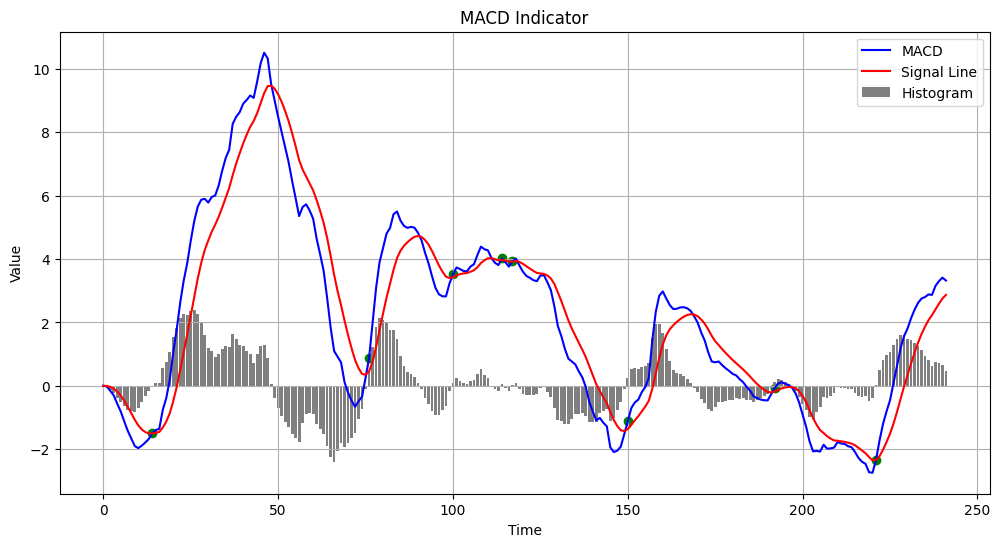

In [ ]:
# Tính EMA (Hàm tính EMA trong pandas)
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

# Tính MACD và Signal Line
stock['EMA_12'] = calculate_ema(stock['close'], 12)
stock['EMA_26'] = calculate_ema(stock['close'], 26)
stock['MACD'] = stock['EMA_12'] - stock['EMA_26']
stock['Signal_Line'] = calculate_ema(stock['MACD'], 9)

# Tính Histogram
stock['Histogram'] = stock['MACD'] - stock['Signal_Line']

# Vẽ biểu đồ MACD
plt.figure(figsize=(12, 6))

for i in range(1, len(stock)):
    if stock['MACD'][i-1] < stock['Signal_Line'][i-1] and stock['MACD'][i] > stock['Signal_Line'][i]:
        plt.scatter(i, stock['MACD'][i], color='green', label='Buy Signal' if i == 1 else '')
plt.plot(stock['MACD'], label='MACD', color='blue')
plt.plot(stock['Signal_Line'], label='Signal Line', color='red')
plt.bar(stock.index, stock['Histogram'], label='Histogram', color='gray')
plt.title('MACD Indicator')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
stock

,time,close,volume,EMA_12,EMA_26,MACD,Signal_Line,Histogram
0,2024-01-02,105.3,235826,105.300000,105.300000,0.000000,0.000000,0.000000
1,2024-01-03,105.0,453700,105.253846,105.277778,-0.023932,-0.004786,-0.019145
2,2024-01-04,103.5,776157,104.984024,105.146091,-0.162067,-0.036242,-0.125824
3,2024-01-05,103.0,320453,104.678789,104.987121,-0.308332,-0.090660,-0.217671
4,2024-01-08,101.1,489480,104.128206,104.699186,-0.570980,-0.186724,-0.384256
...,...,...,...,...,...,...,...,...
237,2024-12-13,181.9,219200,179.792027,176.922945,2.869082,2.229761,0.639321
238,2024-12-16,186.0,649500,180.747100,177.595320,3.151780,2.414165,0.737615
239,2024-12-17,185.6,414900,181.493700,178.188259,3.305441,2.592420,0.713021
240,2024-12-18,185.9,367100,182.171592,178.759499,3.412093,2.756355,0.655738


In [ ]:
# Tính EMA (Hàm tính EMA trong pandas)
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

# Tính MACD và Signal Line
stock['EMA_12'] = calculate_ema(stock['close'], 12)
stock['EMA_26'] = calculate_ema(stock['close'], 26)
stock['MACD'] = stock['EMA_12'] - stock['EMA_26']
stock['Signal_Line'] = calculate_ema(stock['MACD'], 9)

# Tính Histogram
stock['Histogram'] = stock['MACD'] - stock['Signal_Line']


signals = []
if stock['MACD'].iloc[-1] > stock['Signal_Line'].iloc[-1] and stock['MACD'].iloc[-2] <= stock['Signal_Line'].iloc[-2]:
  signals.append('mua')

In [ ]:
symbol_stock= Vnstock().stock(source='VCI')
symbol_stock = symbol_stock.listing.symbols_by_group('HOSE')

stocks_above_sma50 = []
for i in symbol_stock:
   if symbol_stock not in ["FUEBFVND", "RDP", "KWA", "MTX", "TNV"]:
    try:
      stock = Vnstock().stock(symbol=i, source='VCI')
      stock = stock.quote.history(start='2024-01-01', end ='2024-12-25')
      stock['SMA50'] = stock['close'].rolling(window=50).mean().iloc[-1]
    except Exception as e:
              print(f"Đã xảy ra lỗi khi lấy dữ liệu cho {symbol}: {e}")
              continue

    # list all stock in HOSE having close price > SMA50
    if stock['close'].iloc[-1] > stock['SMA50'].iloc[-1]:
        stocks_above_sma50.append(i)

print("Danh sách cổ phiếu sàn HOSE có giá đóng cửa > SMA50:")
print(stocks_above_sma50)

2024-12-25 07:52:07 - vnstock3.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
INFO:vnstock3.common.vnstock:Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2024-12-25 07:52:07 - vnstock3.common.data.data_explorer - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
INFO:vnstock3.common.data.data_explorer:Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2024-12-25 07:52:08 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-12-25 07:52:14 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-12-25 07:52:17 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-12-25 07:52:19 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-12-25

ValueError: Không tìm thấy dữ liệu. Vui lòng kiểm tra lại mã chứng khoán hoặc thời gian truy xuất.